In [1]:
#check python version
import sys
print(sys.version)
#!$sys.executable -m pip install pystan
#!$sys.executable -m pip install prophet
#!which python
#sys.executable

3.9.12 (main, Jun  1 2022, 06:34:44) 
[Clang 12.0.0 ]


In [2]:
#import packages needed
import os
import numpy as np
import pandas as pd
import matplotlib as plt
import alpaca_trade_api as tradeapi
from prophet import Prophet
from datetime import datetime, timedelta, date

/Users/omer/opt/miniconda3/envs/proph/lib/python3.9/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


In [3]:
# API login Info for fetching data, portfolio, etc. from Alpaca
BASE_URL = "https://paper-api.alpaca.markets"
ALPACA_API_KEY = "--redacted--"
ALPACA_SECRET_KEY = "--redacted--"

In [4]:
# Instantiate REST API Connection
api = tradeapi.REST(key_id=ALPACA_API_KEY, secret_key=ALPACA_SECRET_KEY, 
                    base_url=BASE_URL, api_version='v2')

In [5]:
# Fetch Account
account = api.get_account()
# Print Account Details
print("account id: ")
print(account.id)
print("equity: ")
print(account.equity)
print("status: ")
print(account.status)

account id: 
6c057de8-2343-4636-b194-9b580a06c9c2
equity: 
97862.69
status: 
ACTIVE


In [6]:
# Fetch data for Apple data for predetermined amount of days
daycount = 100 # how many days to get data for

#minutes=15 because alpaca free stream needs to be 15+ min old
#hours=-4 because NY time, input needs to be for UTC
today = datetime.now() - timedelta(minutes=15, hours=-4)
#Optional sleep while pre market is closed
if False:
    while(today.hour < 8 or today.minute < 15):
        print(today.strftime("%H:%M:%S") + ": Market not open.")
        while(today.second != 0):
            time.sleep(1)
            today = datetime.now() - timedelta(minutes=15, hours=-4)
        time.sleep(60)
        today = datetime.now() - timedelta(minutes=15, hours=-4)

#Fetch data
d1 = (today).isoformat() + "Z"
d2 = (date.today() - timedelta(days=daycount)).strftime("%Y-%m-%d")
traindata = api.get_bars_iter('AAPL', tradeapi.TimeFrame.Hour, d2, d1, adjustment='raw')

In [7]:
# Modify input to hold hourly open prices
i = 0
for bar in traindata:
    #print(bar)
    if(i == 0):
        #print(bar.t)
        #print(bar.t.tz_localize(None))
        tra = np.array([[bar.t.tz_localize(None), bar.o]])
        i = i + 1
    else:
        tra = np.append(tra, np.array([[bar.t.tz_localize(None), bar.o]]), axis=0)
train = pd.DataFrame(tra)
train.columns = ['ds', 'y']
print(train)
#print(train.shape)

                      ds       y
0    2022-04-01 04:00:00  175.25
1    2022-04-01 05:00:00  175.32
2    2022-04-01 06:00:00  175.43
3    2022-04-01 07:00:00  175.54
4    2022-04-01 08:00:00  174.83
...                  ...     ...
1067 2022-07-08 15:00:00  147.46
1068 2022-07-08 16:00:00  147.03
1069 2022-07-08 17:00:00     147
1070 2022-07-08 18:00:00  146.97
1071 2022-07-08 19:00:00  146.99

[1072 rows x 2 columns]


In [8]:
# Init prophet and fit open prices

m = Prophet()
m.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/Users/omer/opt/miniconda3/envs/proph/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -4.54401
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3846.8   0.000412681       875.494       0.316       0.316      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3870.73    0.00277106       353.799           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3884.07    0.00550625       1048.25           1           1      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3895.39    0.00344002       474.319           1           1      450   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3902.52     0.0105072       444.195           1           1      566   
    Iter      log prob        ||dx||      ||grad||       alpha  

  3905.07   0.000128764       244.282      0.2866      0.2866      683   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699        3906.7    0.00164476       291.218           1           1      795   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     762       3907.57   9.54068e-05       593.923   2.379e-07       0.001      910  LS failed, Hessian reset 
     799       3908.27   0.000816263       533.661      0.8427      0.8427      952   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899        3909.1   6.23412e-05        89.935           1           1     1068   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999        3910.3     0.0160529       320.774           1           1     1182   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    109

In [9]:
# Predict
future = m.make_future_dataframe(periods=1)
future.tail()

,ds
1068,2022-07-08 16:00:00
1069,2022-07-08 17:00:00
1070,2022-07-08 18:00:00
1071,2022-07-08 19:00:00
1072,2022-07-09 19:00:00


In [10]:
# Forecast
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

/Users/omer/opt/miniconda3/envs/proph/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/omer/opt/miniconda3/envs/proph/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


,ds,yhat,yhat_lower,yhat_upper
1068,2022-07-08 16:00:00,143.472243,140.468789,146.862911
1069,2022-07-08 17:00:00,143.452949,140.160281,146.635612
1070,2022-07-08 18:00:00,143.390142,140.239149,146.423098
1071,2022-07-08 19:00:00,143.505340,140.429809,146.602202
1072,2022-07-09 19:00:00,142.888902,139.524829,146.049914


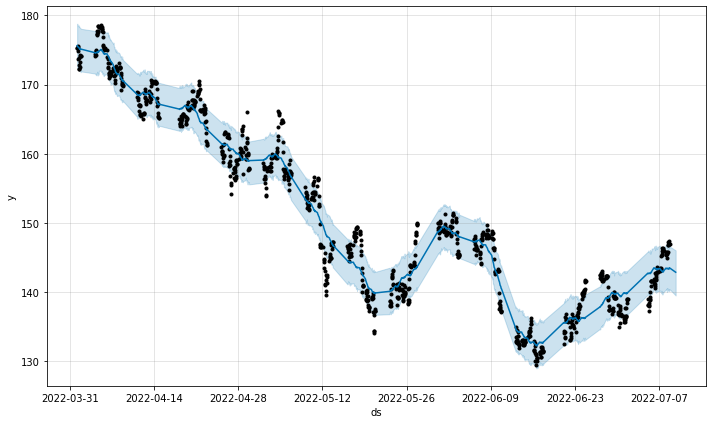

In [11]:
# Plot
fig1 = m.plot(forecast)

/Users/omer/opt/miniconda3/envs/proph/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/omer/opt/miniconda3/envs/proph/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


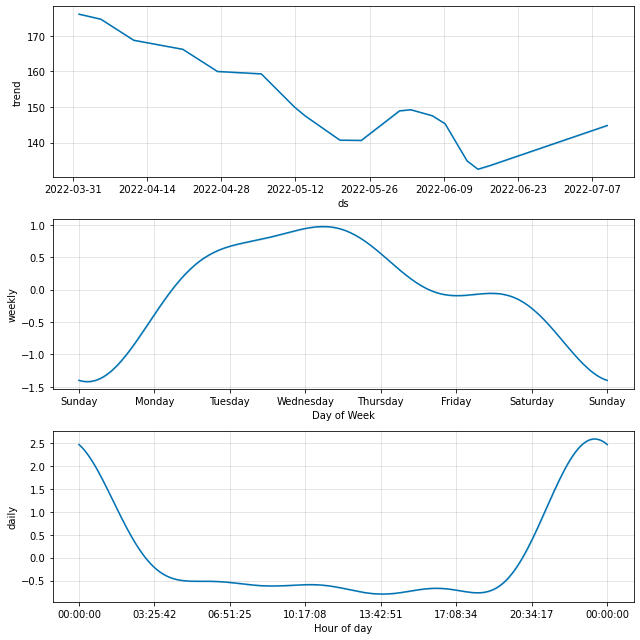

In [12]:
#Plot components
fig2 = m.plot_components(forecast)